In [1]:
import jupyros as jr
import rospy
import numpy as np
from sensor_msgs import msg
import cv2
import cv_bridge
from copy import deepcopy
import ipywidgets as widgets
from IPython.display import clear_output, Image, display
import PIL.Image
from cStringIO import StringIO
import matplotlib.pyplot as plt
import dvrk
import PyKDL
import tf
import time
from tf_conversions import posemath

In [2]:
rospy.init_node('notebook')
rospy.get_published_topics()

[['/dvrk/setup_joint/robot_state', 'std_msgs/String'],
 ['/dvrk/PSM1/current_state', 'std_msgs/String'],
 ['/dvrk/ECM/wrench_body_current', 'geometry_msgs/WrenchStamped'],
 ['/stereo/right/image_flipped', 'sensor_msgs/Image'],
 ['/dvrk/PSM3/goal_reached', 'std_msgs/Bool'],
 ['/dvrk/PSM2/position_cartesian_local_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/SUJ/ECM/position_cartesian_local_current',
  'geometry_msgs/PoseStamped'],
 ['/dvrk/SUJ/PSM2/position_cartesian_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/PSM3/state_joint_current', 'sensor_msgs/JointState'],
 ['/dvrk/console/teleop/teleop_psm_selected', 'diagnostic_msgs/KeyValue'],
 ['/dvrk/PSM2/joint_velocity_ratio', 'std_msgs/Float64'],
 ['/dvrk/PSM3/current_state', 'std_msgs/String'],
 ['/dvrk/PSM3/manip_clutch', 'std_msgs/Bool'],
 ['/dvrk/PSM3/position_cartesian_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/ECM/state_joint_desired', 'sensor_msgs/JointState'],
 ['/dvrk/console/teleop/teleop_psm_unselected', 'diagnosti

In [3]:
bridge = cv_bridge.CvBridge()
left_image = None
left_image_msg = None
left_camera_info = None

right_image = None
right_image_msg = None
right_camera_info = None

def left_image_callback(im_msg):
    global left_image, left_image_msg
    left_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    left_image_msg = im_msg
    
def right_image_callback(im_msg):
    global right_image, right_image_msg
    right_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    right_image_msg = im_msg
    
def left_camera_info_callback(camera_info_msg):
    global left_camera_info
    left_camera_info = camera_info_msg
    
def right_camera_info_callback(camera_info_msg):
    global right_camera_info
    right_camera_info = camera_info_msg
    
jr.subscribe('/stereo/left/image_flipped', msg.Image, left_image_callback)
jr.subscribe('/stereo/left/camera_info', msg.CameraInfo, left_camera_info_callback)
jr.subscribe('/stereo/right/image_flipped', msg.Image, right_image_callback)
jr.subscribe('/stereo/right/camera_info', msg.CameraInfo, right_camera_info_callback)

while left_image is None or right_image is None:
    #print("left or right image not receieved")
    time.sleep(0.5)
    
print("left or right image receieved")

left or right image receieved


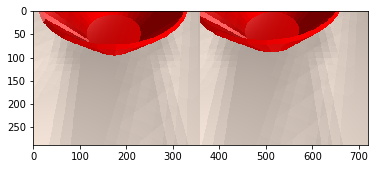

In [4]:
plt.imshow(np.hstack((left_image, right_image)))

In [5]:
print("LEFT CAM")
print(left_camera_info)
print("RIGHT_CAM")
print(right_camera_info)

LEFT CAM
header: 
  seq: 840
  stamp: 
    secs: 1621891032
    nsecs: 511609554
  frame_id: "left_camera"
height: 288
width: 360
distortion_model: "plumb_bob"
D: [0.0, 0.0, 0.0, 0.0, 0.0]
K: [311.9603517065951, 0.0, 180.0, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 1.0]
R: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
P: [311.9603517065951, 0.0, 180.0, 0.0, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 0.0, 1.0, 0.0]
binning_x: 1
binning_y: 1
roi: 
  x_offset: 0
  y_offset: 0
  height: 0
  width: 0
  do_rectify: True
RIGHT_CAM
header: 
  seq: 840
  stamp: 
    secs: 1621891032
    nsecs: 511609554
  frame_id: "right_camera"
height: 288
width: 360
distortion_model: "plumb_bob"
D: [0.0, 0.0, 0.0, 0.0, 0.0]
K: [311.9603517065951, 0.0, 180.0, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 1.0]
R: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0]
P: [311.9603517065951, 0.0, 180.0, -1.5598017585329753, 0.0, 311.9603517065951, 144.0, 0.0, 0.0, 0.0, 1.0, 0.0]
binning_x: 1
binning_y: 1
roi: 
  x_offset: 0
  y_

In [6]:
tf_listener = tf.TransformListener()
time.sleep(1)
tf_listener.getFrameStrings()

/home/iandre/dvrk_ws/src/geometry/tf/src/tf/listener.py:97: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(self._buffer.all_frames_as_yaml()) or {}


['PSM2_tool_wrist_shaft_link',
 'PSM3_outer_pitch_bottom_link',
 'PSM1_RCM',
 'PSM3_outer_pitch_front_link',
 'PSM2_tool_main_link',
 'PSM2_outer_insertion_link',
 'PSM1_tool_wrist_sca_ee_link_0',
 'PSM1_tool_wrist_sca_ee_link_1',
 'PSM1_tool_wrist_sca_ee_link_2',
 'PSM2_outer_pitch_bottom_link',
 'PSM2_tool_wrist_caudier_link_shaft',
 'PSM3_tool_wrist_link',
 'ECM',
 'PSM1_outer_pitch_link',
 'PSM2_base',
 'camera',
 'PSM1_outer_pitch_front_link',
 'ecm_pitch_link',
 'PSM2_RCM',
 'PSM2_tool_wrist_caudier_link',
 'PSM3_tool_wrist_caudier_link_2_right',
 'ecm_pitch_link_1',
 'ecm_pitch_link_2',
 'PSM3_tool_wrist_caudier_ee_link',
 'PSM1_tool_wrist_sca_link',
 'PSM2_outer_pitch_top_link',
 'PSM3_tool_wrist_caudier_link_2_left',
 'PSM3_outer_pitch_back_link',
 'PSM1_outer_pitch_top_link',
 'Vision_sensor_left',
 'simworld',
 'PSM2_tool_wrist_caudier_link_2_right',
 'ecm_base_link',
 'PSM1_tool_wrist_link',
 'PSM1_tool_main_link',
 'PSM3_tool_wrist_caudier_ee_link_0',
 'PSM2_tool_wrist_lin

In [7]:
psm1 = None 
ecm = None
suj = None
debug_output = widgets.Output(layout={'border': '1px solid black'})

with debug_output:
    global psm1, psm2, psm3, ecm
    psm1 = dvrk.psm('PSM1')
    ecm = dvrk.ecm('ECM')
    psm2 = dvrk.psm('PSM2')
    psm3 = dvrk.psm('PSM3')
    
    psm1_suj = dvrk.suj('PSM1')
    psm2_suj = dvrk.suj('PSM2')
    psm3_suj = dvrk.suj('PSM3')
    ecm_suj = dvrk.suj('ECM')
    
while ecm.get_current_position() == PyKDL.Frame() or ecm.get_desired_position() == PyKDL.Frame():
    time.sleep(0.5)
while psm1.get_current_position() == PyKDL.Frame() or psm1.get_desired_position() == PyKDL.Frame():
    time.sleep(0.5)
while psm2.get_current_position() == PyKDL.Frame() or psm2.get_desired_position() == PyKDL.Frame():
    time.sleep(0.5)
# while psm3.get_current_position() == PyKDL.Frame() or psm3.get_desired_position() == PyKDL.Frame():
#     time.sleep(0.5)

In [8]:
from math import radians as r

# 2 arm setup
sm1 = [0.5, -2.4958207607269287, 2.775073528289795, 0.13962633907794952, -0.5235987901687622]
sm2 = [0.5, 2.6005406379699707, -2.7227137088775635, -0.20943951606750488, -0.7155849933624268]
cm = [1.0, -1.2042771577835083, 2.687807083129883, -1.4311699867248535]

# 3 arm setup
# height, shoulder, elbow, wrist, rotate
# sm1 = [-0.0, -1.3, 1.9, -0.1, -0.8]  # right
# sm2 = [-0.0, 1.3, -1.8, -0.2, -0.8]  #  left
# sm3 = [0.35, 2.1, -1.8, -1.0, -1.4]  # middle
# cm = [0.52, 0.7, -1.6, 0.9]
time.sleep(1)

psm1_suj.move_joint(np.asarray(sm1))
psm2_suj.move_joint(np.asarray(sm2))
# psm3_suj.move_joint(np.asarray(sm3))
ecm_suj.move_joint(np.asarray(cm))

print(psm1_suj.get_current_joint_position())
print(psm2_suj.get_current_joint_position())
# print(psm3_suj.get_current_joint_position())
print(ecm_suj.get_current_joint_position())
print('----------------------------------')
print(psm1_suj.get_current_position())
print(psm2_suj.get_current_position())
# print(psm3_suj.get_current_position())
print(ecm_suj.get_current_position())

0.0
0.0
0.0
----------------------------------
[[ 3.33067e-16,          -1,           0;
            1, 3.33067e-16,           0;
            0,           0,           1]
[     -1.9501,   -0.101602,      0.9088]]
[[ 3.33067e-16,           1,           0;
           -1, 3.33067e-16,          -0;
           -0,           0,           1]
[      1.9501,   -0.101598,      0.9088]]
[[          -1, 6.27081e-06, 2.59709e-06;
 -6.27081e-06,   -0.707176,   -0.707037;
 -2.59709e-06,   -0.707037,    0.707176]
[  3.6871e-06,    0.495318,    0.329477]]


In [9]:
# 3 arm setup
# ecm: rotate, up/down, zoom, rotate view
# HARDCODED_ECM_POS = np.array([-0.35, -0.3, 0.15, 0.0])
# PSM_HOME_POS = np.asarray([0.0, 0.2, 0.05, 0.0, 0.0, 0.0])
# 2 arm setup
HARDCODED_ECM_POS = np.array([0.0, 0.0, 0.0, 0.0])
PSM_HOME_POS = np.asarray([0., 0., 0.12, 0., 0., 0.])
time.sleep(1)

psm1.move_joint(deepcopy(PSM_HOME_POS))
psm1.close_jaw()
time.sleep(1)

psm2.move_joint(deepcopy(PSM_HOME_POS))
psm2.close_jaw()
time.sleep(1)

# psm3.move_joint(deepcopy(PSM_HOME_POS))
# psm3.close_jaw()
# time.sleep(1)

ecm.move_joint(HARDCODED_ECM_POS)

True

In [11]:
pick_and_place_utils = None
from pick_and_place_utils import get_objects_and_img, tf_to_pykdl_frame, PSM_J1_TO_BASE_LINK_TF, World
import image_geometry

time.sleep(1)

print(tf_listener.lookupTransform('simworld', 'Vision_sensor_left', rospy.Time()))

rot = PyKDL.Rotation.Quaternion(-0.693885087966919, -0.6698706746101379, -0.18196725845336914, -0.191532701253891)
pos2 = PyKDL.Vector(-1.5822665691375732, 0.009578842669725418, 0.7953448295593262)
tf_cam_to_world = PyKDL.Frame(rot, pos2)

# tf_cam_to_world = tf_to_pykdl_frame(tf_listener.lookupTransform('simworld', 'Vision_sensor_left', rospy.Time()))

# tf_world_to_psm1 = tf_to_pykdl_frame(tf_listener.lookupTransform('PSM1_base', 'simworld', rospy.Time()))
# tf_world_to_psm2 = tf_to_pykdl_frame(tf_listener.lookupTransform('PSM2_base', 'simworld', rospy.Time()))
# tf_world_to_psm3 = tf_to_pykdl_frame(tf_listener.lookupTransform('PSM3_base', 'simworld', rospy.Time()))

tf_world_to_psm1_j1 = tf_to_pykdl_frame(tf_listener.lookupTransform('J1_PSM1', 'simworld', rospy.Time()))
tf_world_to_psm1_base = PSM_J1_TO_BASE_LINK_TF * tf_world_to_psm1_j1

tf_world_to_psm2_j1 = tf_to_pykdl_frame(tf_listener.lookupTransform('J1_PSM2', 'simworld', rospy.Time()))
tf_world_to_psm2_base = PSM_J1_TO_BASE_LINK_TF * tf_world_to_psm2_j1

# tf_world_to_psm3_j1 = tf_to_pykdl_frame(tf_listener.lookupTransform('J1_PSM3', 'world', rospy.Time()))
# tf_world_to_psm3_base = PSM_J1_TO_BASE_LINK_TF * tf_world_to_psm3_j1

print(tf_cam_to_world)
print("==========================")
print(tf_world_to_psm1_base)
print(tf_world_to_psm2_base)
# print(tf_world_to_psm3_base)

([-1.5822665691375732, 0.009578842669725418, 0.7953448295593262], [-0.693885087966919, -0.6698706746101379, -0.18196725845336914, -0.191532701253891])
[[   0.0363225,    0.859921,    0.509133;
     0.999332,  -0.0291771,  -0.0220143;
  -0.00407555,    0.509592,   -0.860406]
[    -1.58227,  0.00957884,    0.795345]]
[[    0.341784,    0.939779,-9.47923e-06;
    -0.939779,    0.341784, 0.000346971;
  0.000329316,-0.000109681,           1]
[    0.655042,    -1.39907,   -0.798299]]
[[   -0.342091,    0.939667, 5.71675e-06;
    -0.939667,   -0.342091, 0.000349853;
  0.000330701, 0.000114309,           1]
[   -0.656837,    -1.40013,   -0.798295]]


In [12]:
stereo_cam = image_geometry.StereoCameraModel()
stereo_cam.fromCameraInfo(left_camera_info, right_camera_info)

objects, frame = get_objects_and_img(left_image_msg, right_image_msg, stereo_cam, 
                                          cam_to_world_tf=tf_cam_to_world)
world = World(objects)

print(objects)
# print(world)

# world.objects[0].pos = PyKDL.Vector(-1.50477, 0.0522653,    0.638678)
# world.objects[1].pos = PyKDL.Vector(-1.52753,   -0.0570536,    0.64815)
# world.objects[2].pos = PyKDL.Vector(-1.52713,   0.0725058,    0.645074)
# world.objects[3].pos = PyKDL.Vector(-1.5363,   0.0332948,    0.640649)
# world.objects[4].pos = PyKDL.Vector(-1.54048,   -0.0341018,    0.63990)
# world.objects[5].pos = PyKDL.Vector(-1.55284,   -0.0612215,    0.649762)
# world.bowl.pos = PyKDL.Vector(-1.46674, 0.00650513, 0.662357)

print(frame)
print(world)

[<Object3d pos: [    -1.46674,  0.00650513,    0.662357] type: FeatureType.BOWL color: 0>, <Object3d pos: [    -1.50477,   0.0522653,    0.638678] type: FeatureType.BALL color: 2>, <Object3d pos: [    -1.52753,  -0.0570536,     0.64815] type: FeatureType.BALL color: 2>, <Object3d pos: [    -1.52713,   0.0725058,    0.645074] type: FeatureType.BALL color: 0>, <Object3d pos: [     -1.5363,   0.0332948,    0.640649] type: FeatureType.BALL color: 1>, <Object3d pos: [    -1.54048,  -0.0341018,    0.639905] type: FeatureType.BALL color: 1>, <Object3d pos: [    -1.55284,  -0.0612215,    0.649762] type: FeatureType.BALL color: 0>]
[[[212 198 188]
  [210 196 186]
  [210 196 186]
  ...
  [191 178 169]
  [191 178 169]
  [182 170 161]]

 [[210 196 186]
  [216 202 192]
  [216 202 192]
  ...
  [187 174 165]
  [187 174 165]
  [187 174 165]]

 [[214 200 190]
  [214 200 190]
  [214 200 190]
  ...
  [187 175 166]
  [189 176 167]
  [187 174 165]]

 ...

 [[240 225 213]
  [240 225 213]
  [241 225 213]
  .

In [13]:
len(objects)

7

[    -1.46674,  0.00650513,    0.662357]


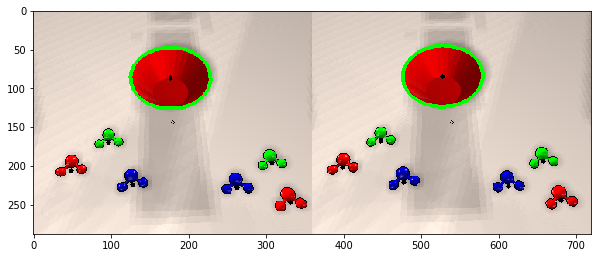

In [14]:
# bowl object position
bowl_pos_cam = objects[0].pos
print(bowl_pos_cam)

plt.figure(figsize=(10, 5))
plt.imshow(frame)

In [15]:
from pick_and_place_arm_sm import PickAndPlaceStateMachine, PickAndPlaceState
from pick_and_place_three_arm_sm import PickAndPlaceThreeArmStateMachine
from pick_and_place_hsm import PickAndPlaceHSM
import IPython
from timeit import default_timer as timer
from pick_and_place_utils import get_objects_for_psms
from enum import Enum
the_image = IPython.display.Image(frame)

objects_to_pick = deepcopy(world.objects)

# this vector is empirically determined
#approach_vec = PyKDL.Vector(0.007, 0.0, -0.015)
approach_vec = PyKDL.Vector(0.000, 0.00, -0.000)

In [ ]:
start_time = time.time()

class TaskType(Enum):
    OneArmFSM = 0
    ThreeArmFSM = 1
    ThreeIndependentFSM = 2
    HCFSM = 3

    
# change this line to change which task is run
task_type = TaskType.OneArmFSM


start_time = time.time()
if task_type == TaskType.OneArmFSM:
    # ========================================================================================================== 
    # Runs 1 FSM
    # ========================================================================================================== 
    sm = PickAndPlaceStateMachine(psm1, world, tf_world_to_psm1_base, None, approach_vec, closed_loop=True,
                                  log_verbose=True)

    while not (sm.is_done() or sm.state == PickAndPlaceState.HOME):
        objects, frame = get_objects_and_img(left_image_msg, right_image_msg, stereo_cam, tf_cam_to_world)
        world = World(objects)
        sm.update_world(world)
        sm.run_once()
        
elif task_type == TaskType.ThreeArmFSM:
    # ==================================================Arm======================================================== 
    # This runs the single FSM that runs both arms sequentially
    # ========================================================================================================== 
    sm = PickAndPlaceThreeArmStateMachine([psm1, psm2, psm3], [tf_world_to_psm1_base, tf_world_to_psm2_base,
                                        tf_world_to_psm3_base], world, approach_vec, log_verbose=True)
    
    while not sm.is_done():
        objects, frame = get_objects_and_img(left_image_msg, right_image_msg, stereo_cam, tf_cam_to_world)
        world = World(objects)
        sm.update_world(world)
        sm.run_once()
        
elif task_type == TaskType.ThreeIndependentFSM:
    # ========================================================================================================== 
    # Runs 3 independent FSMs, one for each arm
    # ========================================================================================================== 

    objects, frame = get_objects_and_img(left_image_msg, right_image_msg, stereo_cam, tf_cam_to_world)
    world = World(objects)
    original_bowl = world.bowl

    # assign objects to PSM1/PSM2 state machines
    psm_object_dict = get_objects_for_psms(world.objects, [tf_world_to_psm1_base, tf_world_to_psm2_base, tf_world_to_psm3_base])


    psm1_sm = PickAndPlaceStateMachine(psm1, world, tf_world_to_psm1_base, None, approach_vec,
                                      closed_loop=True, pick_closest_to_base_frame=True)

    psm2_sm = PickAndPlaceStateMachine(psm2, world, tf_world_to_psm2_base, None, approach_vec,
                                      closed_loop=True, pick_closest_to_base_frame=True)
    
    psm3_sm = PickAndPlaceStateMachine(psm3, world, tf_world_to_psm3_base, None, approach_vec,
                                      closed_loop=True, pick_closest_to_base_frame=True)

    # because we exit out of the loop as soon as both arms are in the HOME state 
    # (i.e. they have began to move to the home position), the end time is exactly the first 'tick' after
    # the last arm has opened its gripper past 60 degrees
    while (psm1_sm.state != PickAndPlaceState.HOME) or (psm2_sm.state != PickAndPlaceState.HOME) or (psm3_sm.state != PickAndPlaceState.HOME):
        objects, frame = get_objects_and_img(left_image_msg, right_image_msg, stereo_cam, tf_cam_to_world)
        world = World(objects)
        psm1_sm.update_world(world)
        psm2_sm.update_world(world)
        psm3_sm.update_world(world)
        psm1_sm.run_once()
        psm2_sm.run_once()
        psm3_sm.run_once()
        
elif task_type == TaskType.HCFSM:
    # ========================================================================================================== 
    # This runs the hierarchical concurrent state machine that runs both arms concurrently
    # ========================================================================================================== 
    hsm = PickAndPlaceHSM([psm1, psm2], [tf_world_to_psm1_base, tf_world_to_psm2_base], world, approach_vec, 
                          log_verbose=False)

    while not hsm.is_done():
        objects, frame = get_objects_and_img(left_image_msg, right_image_msg, stereo_cam, tf_cam_to_world)
        world = World(objects)
        hsm.update_world(world)
        hsm.run_once()

[INFO] [1621891139.183372]: PickAndPlaceStateMachine:__init__
[INFO] [1621891139.322146]: psm: PSM1, world: <World objects: [<Object3d pos: [    -1.50477,   0.0522653,    0.638678] type: FeatureType.BALL color: 2>, <Object3d pos: [    -1.52753,  -0.0570536,     0.64815] type: FeatureType.BALL color: 2>, <Object3d pos: [    -1.52713,   0.0725058,    0.645074] type: FeatureType.BALL color: 0>, <Object3d pos: [     -1.5363,   0.0332948,    0.640649] type: FeatureType.BALL color: 1>, <Object3d pos: [    -1.54048,  -0.0341018,    0.639905] type: FeatureType.BALL color: 1>, <Object3d pos: [    -1.55284,  -0.0612215,    0.649762] type: FeatureType.BALL color: 0>]
bowl: <Object3d pos: [    -1.46674,  0.00650513,    0.662357] type: FeatureType.BOWL color: 0>>, world_to_psm_tf: [[    0.341784,    0.939779,-9.47923e-06;
    -0.939779,    0.341784, 0.000346971;
  0.000329316,-0.000109681,           1]
[    0.655042,    -1.39907,   -0.798299]], object: None
[INFO] [1621891139.444632]: home_when_don

[INFO] [1621891167.900509]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1621891168.257616]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1621891168.837959]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1621891169.367972]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1621891169.415549]: Picking Object [    -1.54048,  -0.0341018,    0.639905]
[INFO] [1621891169.528363]: Setting PSM1 dest to [   0.0964783,   0.0372017,   -0.158898]
[INFO] [1621891170.049163]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1621891170.124899]: Picking Object [    -1.54048,  -0.0341018,    0.639905]
[INFO] [1621891170.191766]: Setting PSM1 dest to [   0.0964783,   0.0372017,   -0.158898]
[INFO] [1621891170.725231]: Running state PickAndPlaceState.GRAB_OBJECT
[INFO] [1621891170.814042]: Setting PSM1 dest to [   0.0964783,   0.0372017,   -0.158898]
[INFO] [1621891171.259818]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1621891171.523911]: Running state PickAndPla

[INFO] [1621891198.528218]: Running state PickAndPlaceState.GRAB_OBJECT
[INFO] [1621891198.576624]: Setting PSM1 dest to [   0.0964783,   0.0372017,   -0.158898]
[INFO] [1621891199.161858]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1621891199.702023]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1621891200.040487]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1621891200.798483]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1621891200.899543]: Setting PSM1 dest to [    0.159842,  -0.0181999,   -0.106426]
[INFO] [1621891201.196604]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1621891201.241720]: Setting PSM1 dest to [    0.159842,  -0.0181999,   -0.106426]
[INFO] [1621891201.587019]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1621891201.698291]: Setting PSM1 dest to [    0.159842,  -0.0181999,   -0.106426]
[INFO] [1621891202.417504]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1621891202.619086]: Running state PickAndPlaceState.DROP

[INFO] [1621891231.533519]: Running state PickAndPlaceState.APPROACH_OBJECT
[INFO] [1621891231.589015]: Picking Object [    -1.54048,  -0.0341018,    0.639905]
[INFO] [1621891231.672078]: Setting PSM1 dest to [   0.0964783,   0.0372017,   -0.158898]
[INFO] [1621891232.077775]: Running state PickAndPlaceState.GRAB_OBJECT
[INFO] [1621891232.171491]: Setting PSM1 dest to [   0.0964783,   0.0372017,   -0.158898]
[INFO] [1621891232.682084]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1621891233.258169]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1621891233.922701]: Running state PickAndPlaceState.CLOSE_JAW
[INFO] [1621891234.663190]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1621891234.791115]: Setting PSM1 dest to [    0.159842,  -0.0181999,   -0.106426]
[INFO] [1621891235.267743]: Running state PickAndPlaceState.APPROACH_DEST
[INFO] [1621891235.347965]: Setting PSM1 dest to [    0.159842,  -0.0181999,   -0.106426]
[INFO] [1621891235.817506]: Running state PickAndP

[INFO] [1621891254.572186]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1621891254.602870]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1621891254.653230]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1621891254.697639]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1621891254.722056]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1621891254.755122]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1621891254.795860]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1621891254.851593]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1621891254.895109]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1621891254.932362]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1621891255.016169]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1621891255.056315]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1621891255.206527]: Running state PickAndPlaceState.DROP_OBJECT
[INFO] [1621891255.257257]: Running state PickAndPlaceState.DROP

In [ ]:
completion_time = time.time()
print("Task took {} seconds".format(completion_time - start_time))

In [ ]:
time.sleep(1)
psm1.move_joint(np.asarray([0., 0., 0.08, 0., 0., 0.]))
psm2.move_joint(np.asarray([0., 0., 0.08, 0., 0., 0.]))

In [ ]:
plt.figure(figsize=(10, 5))
plt.imshow(frame)

In [ ]:
time.time()